## STEP 1: INSTALLATION & IMPORTS

In [2]:
# --- 1. Installation ---
# Cài đặt tất cả các thư viện cần thiết.
# -qU: quiet (im lặng), upgrade (nâng cấp)
print("Bắt đầu cài đặt các thư viện...")
!pip install -qU langgraph langchain langchain-core langchain-community groq python-dotenv rich

Bắt đầu cài đặt các thư viện...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [3]:
!pip install -qU tavily-python google-api-python-client google-auth-oauthlib
print("Đã cài đặt các thư viện công cụ cần thiết.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
Đã cài đặt các thư viện công cụ cần thiết.


In [4]:
!pip install google-auth-httplib2 langchain-groq

In [23]:
# --- 2. Core Imports ---
# Import các thư viện và lớp (class) cốt lõi sẽ được sử dụng trong toàn bộ dự án.
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from google.colab import userdata

# LangChain & LangGraph core components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Groq client for LLM interaction
from groq import AsyncGroq

# Rich library for beautiful printing
from rich.console import Console
from rich.markdown import Markdown

SHOW_DETAILED_LOGS = True
SHOW_DETAILED_LOGS = False
print("\nCài đặt và Import hoàn tất. Môi trường đã sẵn sàng!")



Cài đặt và Import hoàn tất. Môi trường đã sẵn sàng!


## STEP 2: STATE DEFINITION & LLM WRAPPER

In [34]:
# ==============================================================================
# STEP 2: STATE DEFINITION & LANGCHAIN LLM
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator
import json
import os
import tavily
from datetime import datetime, timezone, timedelta

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from rich.console import Console
from rich.markdown import Markdown
from google.colab import userdata
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END

# --- 1. State Definition (Hoàn chỉnh) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else: merged[key] = value
    return merged

class AcademicState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    profile: Dict
    cross_agent_request: Optional[Dict[str, Any]]
    required_agents: List[str]
    completed_agents: Annotated[List[str], operator.add]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts]
    critique: str
    revision_needed: bool
    revision_count: int
    final_report: str
    next_steps: str

print("Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.")

# --- 2. Khởi tạo LLM ---
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
    llm = ChatGroq(
        temperature=0.2, # Giảm độ "sáng tạo" để agent tuân thủ hướng dẫn hơn
        model="llama3-70b-8192",
        api_key=GROQ_API_KEY,
        max_tokens=4096
    )
    print(f"Khởi tạo ChatGroq thành công với model: {llm.model_name}")
except Exception as e:
    print(f"LỖI: Không thể khởi tạo LLM. {e}")
    llm = None
console = Console()
if llm: print("\nKhởi tạo 'llm' và 'console' thành công.")



Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.
Khởi tạo ChatGroq thành công với model: llama3-70b-8192

Khởi tạo 'llm' và 'console' thành công.


In [35]:
# ==============================================================================
# STEP 3: THE TOOLBOX
# ==============================================================================
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

# --- 1. Khởi tạo các service và dữ liệu ---
SERVICE_ACCOUNT_FILE = 'credentials.json'
YOUR_CALENDAR_ID = "td.tan2711@gmail.com"

def authenticate_google_calendar_service_account():
    try:
        if not os.path.exists(SERVICE_ACCOUNT_FILE): return None
        SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']
        creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        service = build('calendar', 'v3', credentials=creds)
        print("✅ Xác thực Google Calendar thành công.")
        return service
    except Exception as e:
        print(f"Lỗi khi xác thực Google Calendar: {e}")
        return None
google_calendar_service = authenticate_google_calendar_service_account()

# <-- ĐÃ XÓA PHẦN ĐỌC TASKS.JSON

try:
    with open('profile.json', 'r', encoding='utf-8') as f: profile_data = json.load(f)
    print("✅ Đã tải dữ liệu profile.json thành công.")
except Exception as e:
    profile_data = {}
    print(f"Lỗi khi tải profile.json: {e}")

# --- 2. Định nghĩa các công cụ ---
@tool
def google_calendar_reader(days_ahead: int = 7) -> str:
    """Đọc lịch và các sự kiện sắp tới của người dùng."""
    if not google_calendar_service: return "Lỗi: Dịch vụ Google Calendar không có sẵn."
    now_utc = datetime.now(timezone.utc).isoformat()
    future_limit = (datetime.now(timezone.utc) + timedelta(days=days_ahead)).isoformat()
    try:
        print(f"--- [Calendar Tool] Đang đọc lịch: {YOUR_CALENDAR_ID}")
        events_result = google_calendar_service.events().list(
            calendarId=YOUR_CALENDAR_ID, timeMin=now_utc, timeMax=future_limit,
            singleEvents=True, orderBy='startTime'
        ).execute()
        events = events_result.get('items', [])
        if not events: return f"Không có sự kiện nào sắp tới trong {days_ahead} ngày tới."
        print(f"--- [Calendar Tool] Tìm thấy {len(events)} sự kiện.")
        return json.dumps([{'summary': e.get('summary'), 'start': e.get('start', {}).get('dateTime'), 'end': e.get('end', {}).get('dateTime')} for e in events])
    except Exception as e: return f"Lỗi khi gọi Google Calendar API: {e}"


@tool
def tavily_web_search(query: str) -> str:
    """Tìm kiếm thông tin học thuật trên Internet."""
    try:
        client = tavily.TavilyClient(api_key=TAVILY_API_KEY)
        response = client.search(query=query, search_depth="advanced", max_results=3)
        return "\n\n".join([f'Source: {res["url"]}\nContent: {res["content"]}' for res in response["results"]])
    except Exception as e: return f"Lỗi khi tìm kiếm với Tavily: {e}"

# --- 3. Tạo danh sách và bind các công cụ ---
# <-- ĐÃ XÓA `active_tasks_reader` KHỎI DANH SÁCH
tools = [google_calendar_reader, tavily_web_search]
llm_with_tools = llm.bind_tools(tools)
print("\n✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.")

✅ Xác thực Google Calendar thành công.
✅ Đã tải dữ liệu profile.json thành công.

✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.


In [36]:
# ==============================================================================
# STEP 4: THE FULL INTERACTIVE TEAM OF AGENTS
# ==============================================================================
import re
import time
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, Dict, Any

# --- 1. Định nghĩa các cấu trúc dữ liệu cho tương tác ---
class FinalAnswer(BaseModel):
    """Sử dụng để cung cấp câu trả lời cuối cùng."""
    answer: str = Field(description="Nội dung câu trả lời cuối cùng, chi tiết bằng Markdown.")

# --- 2. Xây dựng các Agent ---

async def coordinator_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---")

    # <-- NÂNG CẤP: Thêm logic phân tích từ khóa
    prompt = f"""Bạn là một Coordinator Agent bậc thầy. Nhiệm vụ của bạn là phân tích yêu cầu của người dùng để quyết định chính xác agent nào cần được kích hoạt.

    **CÁC AGENT CÓ SẴN VÀ KHI NÀO NÊN DÙNG:**
    - `PLANNER`: CHỈ kích hoạt khi yêu cầu có các từ khóa rõ ràng liên quan đến **lập kế hoạch, lịch trình, sắp xếp thời gian, tuần tới, deadline**.
    - `NOTEWRITER`: Kích hoạt khi yêu cầu liên quan đến **tìm hiểu, tóm tắt, ghi chú, giải thích một chủ đề**.
    - `ADVISOR`: Kích hoạt khi yêu cầu có các từ khóa liên quan đến **lời khuyên, phương pháp, cách học, mẹo**.

    **YÊU CẦU CỦA NGƯỜI DÙNG:**
    "{state['messages'][0].content}"

    Dựa vào các quy tắc trên, hãy phân tích yêu cầu và trả về một danh sách Python chứa tên các agent cần thiết.

    Ví dụ:
    - Yêu cầu: "lập kế hoạch học về RAG cho tuần tới" -> ["PLANNER", "NOTEWRITER"]
    - Yêu cầu: "giải thích cho tôi về RAG" -> ["NOTEWRITER"]
    - Yêu cầu: "cho tôi vài mẹo để học RAG hiệu quả" -> ["ADVISOR", "NOTEWRITER"]
    """

    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    try:
        # Cố gắng tìm danh sách Python trong phản hồi
        # Regex này tìm một chuỗi trông giống như một danh sách Python
        match = re.search(r'\[\s*([^\]]*?)\s*\]', response_message.content)
        if match:
            # Lấy nội dung bên trong dấu ngoặc vuông và chuyển thành danh sách
            agent_list_str = f"[{match.group(1)}]"
            required_agents = eval(agent_list_str)
        else:
            raise ValueError("Không tìm thấy danh sách trong phản hồi")

        if not isinstance(required_agents, list): raise ValueError
    except:
        # Nếu có lỗi, kích hoạt tất cả như một giải pháp an toàn
        required_agents = ["PLANNER", "NOTEWRITER", "ADVISOR"]

    print(f"--- [Coordinator] Quyết định: Cần các agent {required_agents}")
    return {"required_agents": required_agents}

async def tool_user_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Tool User] Thu thập tất cả thông tin ban đầu... ---")
    request = state['messages'][0].content
    search_query = f"Hướng dẫn học và các tài liệu tốt nhất về '{request}'"
    print(f"--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']")
    calendar_output = google_calendar_reader.invoke({"days_ahead": 7})
    time.sleep(1)
    web_output = tavily_web_search.invoke({"query": search_query})
    collected_data = f"""Thông tin ban đầu đã được thu thập:
    1. Lịch trình trong 7 ngày tới: {calendar_output}
    2. Kết quả tìm kiếm trên web: {web_output}"""
    context_message = SystemMessage(content=collected_data)
    print("--- [Tool User] Đã thu thập và định dạng xong thông tin.")
    return {"messages": [context_message]}

def create_specialist_agent(agent_name: str, agent_description: str, output_key: str):
    async def specialist_agent(state: AcademicState) -> Dict[str, Any]:
        print(f"\n--- [{agent_name}] Bắt đầu làm việc... ---")
        llm_with_tool = llm.bind_tools([FinalAnswer])

        if agent_name == "PLANNER":
            prompt_content = f"""Bạn là {agent_name}. {agent_description}.
            Dựa vào thông tin ban đầu (lịch trình, kết quả tìm kiếm), hãy tạo ra một kế hoạch học tập chi tiết, khả thi.
            **Thông tin có sẵn:**
            ```json
            {json.dumps({
                "profile": state['profile'],
                "messages": [msg.model_dump() for msg in state['messages']],
            }, indent=2, ensure_ascii=False)}
            ```
            """
        else:
            prompt_content = f"""Bạn là {agent_name}. {agent_description}.
            Dựa vào KẾ HOẠCH HỌC TẬP đã được tạo ra dưới đây và thông tin ban đầu, hãy tạo ra sản phẩm chuyên môn của bạn.
            **Đừng lặp lại kế hoạch**, hãy tạo ra một nội dung mới dựa trên nó.
            **Thông tin để tham khảo:**
            ```json
            {json.dumps({
                "profile": state['profile'],
                "messages": [msg.model_dump() for msg in state['messages']],
                "agent_outputs": state['agent_outputs'],
            }, indent=2, ensure_ascii=False)}
            ```
            """

        prompt = f"{prompt_content}\nHãy tạo ra câu trả lời cuối cùng của bạn và gọi công cụ `FinalAnswer`."

        try:
            ai_response = await llm_with_tool.ainvoke([HumanMessage(content=prompt)])
            if not ai_response.tool_calls:
                print(f"--- [{agent_name}] Cảnh báo: Không gọi được tool, trả về nội dung thô.")
                return {"agent_outputs": {output_key: ai_response.content}}
            tool_call = ai_response.tool_calls[0]
            if tool_call['name'] == 'FinalAnswer':
                print(f"--- [{agent_name}] Đã tạo sản phẩm thành công.")
                return {"agent_outputs": {output_key: tool_call['args']['answer']}}
            else:
                raise ValueError(f"LLM đã gọi một công cụ không xác định: {tool_call['name']}")
        except Exception as e:
            # --- LOGIC NÂNG CẤP ---
            # Chỉ in lỗi chi tiết nếu đang ở chế độ debug
            if SHOW_DETAILED_LOGS:
                print(f"--- [{agent_name}] Gặp lỗi API: {e}")

            error_str = str(e)
            match = re.search(r'"answer":\s*"(.*?)"', error_str, re.DOTALL)
            if match:
                extracted_answer = match.group(1).encode().decode('unicode_escape')
                print(f"--- [{agent_name}] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.")
                return {"agent_outputs": {output_key: extracted_answer}}
            else:
                print(f"--- [{agent_name}] Không thể cứu sản phẩm. Trả về thông báo lỗi.")
                return {"agent_outputs": {output_key: f"Agent {agent_name} đã gặp lỗi không thể phục hồi."}}
    return specialist_agent

planner_agent = create_specialist_agent("PLANNER", "Tạo kế hoạch học tập chi tiết, khả thi.", "plan")
notewriter_agent = create_specialist_agent("NOTEWRITER", "Tạo ghi chú học thuật súc tích.", "notes")
advisor_agent = create_specialist_agent("ADVISOR", "Đưa ra lời khuyên chiến lược.", "advice")

async def synthesizer_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---")
    prompt = f"Tổng hợp các sản phẩm từ các chuyên gia (Kế hoạch, Ghi chú, Lời khuyên) sau đây thành MỘT báo cáo tổng hợp duy nhất, mạch lạc và chuyên nghiệp cho người dùng:\n\n{json.dumps(state['agent_outputs'], indent=2, ensure_ascii=False)}.\n\nYêu cầu ban đầu của người dùng là: '{state['messages'][0].content}'"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"final_report": response_message.content}

async def reflection_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---")
    prompt = f"Dựa vào báo cáo cuối cùng này, hãy đề xuất 3-4 hành động hoặc câu hỏi tiếp theo mà người dùng có thể muốn thực hiện:\n\n{state['final_report']}"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"next_steps": response_message.content}

print("✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản chuyên môn hóa) đã được định nghĩa.")

✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản chuyên môn hóa) đã được định nghĩa.


In [37]:
# ==============================================================================
# STEP 5 & 6: ASSEMBLY Kiến trúc
# ==============================================================================

# Node wrapper để chạy agent và đánh dấu hoàn thành
async def specialist_node_wrapper(agent_func, agent_name: str, state: AcademicState) -> Dict[str, Any]:
    # Chạy agent
    result = await agent_func(state)

    # Đánh dấu đã hoàn thành
    current_completed = state.get("completed_agents", [])
    if agent_name not in current_completed:
        # Sử dụng toán tử `add` của `Annotated` bằng cách trả về một danh sách
        result["completed_agents"] = [agent_name]

    return result
# Định nghĩa các node một cách tường minh
async def planner_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(planner_agent, "PLANNER", state)

async def notewriter_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(notewriter_agent, "NOTEWRITER", state)

async def advisor_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(advisor_agent, "ADVISOR", state)

# --- Lắp ráp Graph ---
workflow = StateGraph(AcademicState)
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("tool_user", tool_user_agent)
# Sử dụng các hàm async def đã được định nghĩa đúng cách
workflow.add_node("planner", planner_node)
workflow.add_node("notewriter", notewriter_node)
workflow.add_node("advisor", advisor_node)
workflow.add_node("synthesizer", synthesizer_agent)
workflow.add_node("reflection", reflection_agent)

workflow.set_entry_point("coordinator")

# Luồng chạy tuần tự, thẳng và đơn giản

workflow.add_edge("coordinator", "tool_user")
workflow.add_edge("tool_user", "planner")
workflow.add_edge("planner", "notewriter")
workflow.add_edge("notewriter", "advisor")
workflow.add_edge("advisor", "synthesizer")

# Luồng cuối cùng
workflow.add_edge("synthesizer", "reflection")
workflow.add_edge("reflection", END)

app = workflow.compile()
print("\n✅✅✅ ATLAS 2.0 (Kiến trúc cuối cùng) đã được biên dịch! ✅✅✅")


✅✅✅ ATLAS 2.0 (Kiến trúc cuối cùng) đã được biên dịch! ✅✅✅


In [38]:
# ==============================================================================
# STEP 7: EXECUTION
# ==============================================================================

async def run_atlas_2_0(profile_data: dict):
    request = "Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập."

    student_profile = next((p for p in profile_data.get("profiles", []) if p.get("id") == "student_123"), {})

    initial_state = {
        "messages": [HumanMessage(content=request)],
        "profile": student_profile,
        "agent_outputs": {},
        "completed_agents": [],
    }

    console.print(f"\n🚀 [bold blue]Bắt đầu chạy ATLAS 2.0 với yêu cầu:[/bold blue]\n{request}")

    # Chạy và xem log của từng bước
    async for step in app.astream(initial_state, config={"recursion_limit": 15}):
        node_name = list(step.keys())[0]
        console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
        console.print(step[node_name])

# Chạy hàm chính
await run_atlas_2_0(profile_data)

🚀 Bắt đầu chạy ATLAS 2.0 với yêu cầu:
Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học 
tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập.


--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']


✅ Hoàn thành bước: coordinator

{'required_agents': ['PLANNER', 'NOTEWRITER', 'ADVISOR']}


--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.


✅ Hoàn thành bước: tool_user

{
    'messages': [
        SystemMessage(
            content='Thông tin ban đầu đã được thu thập:\n    1. Lịch trình trong 7 ngày tới: [{"summary": "Work 
Online", "start": "2025-08-08T19:45:00+07:00", "end": "2025-08-08T21:15:00+07:00"}, {"summary": "Take a nap", 
"start": "2025-08-11T08:45:00+07:00", "end": "2025-08-11T13:00:00+07:00"}, {"summary": "have a trip", "start": 
"2025-08-12T01:30:00+07:00", "end": "2025-08-12T05:30:00+07:00"}, {"summary": "go swimming", "start": 
"2025-08-14T07:15:00+07:00", "end": "2025-08-14T11:45:00+07:00"}]\n    2. Kết quả tìm kiếm trên web: Source: 
https://aicandy.vn/kham-pha-k-nearest-neighbors-cho-phan-loai-va-hoi-quy/\nContent: 1. Giới thiệu về K-nearest 
neighbors\n   2. Nguyên lý hoạt động của KNN\n       2.1. Các bước thực hiện\n       2.2. Bài toán phân loại\n     
2.4. Bài toán hồi quy\n\n   3. Chọn giá trị của k\n       3.1. Tầm quan trọng của việc chọn giá trị k\n       3.2. 
Ảnh hưởng của giá trị k đến hiệu suất mô hình\n       3.3. Các phương pháp chọn giá trị k\n       3.4. Các yếu tố 
ảnh hưởng đến việc chọn giá trị k\n       3.5. Tối ưu hóa giá trị k cho từng bài toán cụ thể [...] K-nearest 
neighbors (KNN) là một trong những thuật toán học máy cơ bản nhất, nhưng vô cùng mạnh mẽ trong cả bài toán phân 
loại và hồi quy.\n\nKNN là một thuật toán học máy không tham số (non-parametric) và học giám sát (supervised 
learning). Ý tưởng chính là tìm kiếm k điểm dữ liệu gần nhất trong tập huấn luyện, sau đó sử dụng chúng để dự đoán 
nhãn hoặc giá trị của điểm dữ liệu mới.\n\nImage 75: aicandy.vn\n\n2. Nguyên lý hoạt động của 
KNN\n---------------------------------- [...] KNN là một trong những thuật toán đơn giản nhất trong học máy. Không 
cần xây dựng mô hình phức tạp hoặc tìm kiếm các tham số phức tạp, KNN chỉ dựa vào tính toán khoảng cách và tìm kiếm
k hàng xóm gần nhất.\n   Điều này làm cho KNN trở nên dễ dàng để hiểu và triển khai, ngay cả đối với những người 
mới bắt đầu trong lĩnh vực học máy.\n\n#### Không yêu cầu giả định về phân phối dữ liệu\n\nSource: 
https://viblo.asia/p/knn-k-nearest-neighbors-1-djeZ14ejKWz\nContent: 1.   Thuật toán đơn giản, dễ dàng triển 
khai.\n2.   Độ phức tạp tính toán nhỏ.\n3.   Xử lý tốt với tập dữ liệu nhiễu\n\nNhược điểm\n==========\n\n1.   Với 
K nhỏ dễ gặp nhiễu dẫn tới kết quả đưa ra không chính xác\n2.   Cần nhiều thời gian để thực hiện do phải tính toán 
khoảng cách với tất cả các đối tượng trong tập dữ liệu.\n3.   Cần chuyển đổi kiểu dữ liệu thành các yếu tố định 
tính.\n\nTrong bài tiếp theo chúng ta sẽ xây dựng một mã nguồn mô phỏng thuật toán KNN trong thực tế. [...] KNN 
(K-Nearest Neighbors) là một trong những thuật toán học có giám sát đơn giản nhất được sử dụng nhiều trong khai phá
dữ liệu và học máy. Ý tưởng của thuật toán này là nó không học một điều gì từ tập dữ liệu học (nên KNN được xếp vào
loại lazy learning), mọi tính toán được thực hiện khi nó cần dự đoán nhãn của dữ liệu mới. \n\nLớp (nhãn) của một 
đối tượng dữ liệu mới có thể dự đoán từ các lớp (nhãn) của k hàng xóm gần nó nhất.\n\nVí dụ:\n------ [...] 1.   Ta 
có D là tập các điểm dữ liệu đã được gắn nhãn và A là dữ liệu chưa được phân loại.\n2.   Đo khoảng cách (Euclidian,
Manhattan, Minkowski, Minkowski hoặc Trọng số) từ dữ liệu mới A đến tất cả các dữ liệu khác đã được phân loại trong
D.\n3.   Chọn K (K là tham số mà bạn định nghĩa) khoảng cách nhỏ nhất.\n4.   Kiểm tra danh sách các lớp có khoảng 
cách ngắn nhất và đếm số lượng của mỗi lớp xuất hiện.\n5.   Lấy đúng lớp (lớp xuất hiện nhiều lần nhất).\n\nSource:
https://machinelearningcoban.com/2017/01/08/knn/\nContent: K-nearest neighbor là một trong những thuật toán 
supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning. Khi training, 
thuật toán này không học một điều gì từ dữ liệu training (đây cũng là lý do thuật toán này được xếp vào loại lazy 
learning), mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới. K-nearest neighbor có thể áp 
dụng được vào 


--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.


✅ Hoàn thành bước: planner

{
    'agent_outputs': {
        'plan': 'Based on the provided information, I will create a detailed learning plan for you to learn about 
K-Nearest Neighbors (KNN) algorithm.\n\n**Learning Plan:**\n\n* Day 1-2: Review the basics of KNN algorithm, 
including its introduction, working principle, and applications.\n* Day 3-4: Focus on the importance of choosing 
the right value of k, its impact on model performance, and methods for selecting k.\n* Day 5-6: Study the 
advantages and disadvantages of KNN, including its simplicity, low computational complexity, and ability to handle 
noisy data.\n* Day 7: Practice implementing KNN algorithm using a programming language of your choice.\n\n**Study 
Schedule:**\n\n* Morning (9 AM - 12 PM): Study and review KNN algorithm\n* 45-minute focus, 15-minute break\n* Use 
diagrams, mind maps, and videos to aid learning\n\n**Additional Tips:**\n\n* Take breaks to avoid burnout\n* Review
and practice regularly to reinforce learning\n* Use online resources and tutorials to supplement learning\n\nI hope
this learning plan helps you to learn about KNN algorithm effectively!'
    },
    'completed_agents': ['PLANNER']
}


--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Đã tạo sản phẩm thành công.


✅ Hoàn thành bước: notewriter

{
    'agent_outputs': {
        'notes': "Here is a concise note on K-Nearest Neighbors (KNN) algorithm:\n\n**Introduction:** KNN is a 
supervised learning algorithm used for classification and regression tasks.\n\n**Working Principle:** KNN finds the
k-nearest neighbors of a new data point and uses their labels to predict the label of the new data 
point.\n\n**Advantages:** Simple to implement, low computational complexity, and ability to handle noisy 
data.\n\n**Disadvantages:** Sensitive to the choice of k, computationally expensive for large datasets, and 
requires feature scaling.\n\n**Choosing k:** The value of k affects the model's performance, and there is no 
one-size-fits-all solution. Cross-validation can be used to select the optimal value of k.\n\n**Conclusion:** KNN 
is a powerful algorithm for classification and regression tasks, but its performance depends on the choice of k and
the quality of the data."
    },
    'completed_agents': ['NOTEWRITER']
}


--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.


✅ Hoàn thành bước: advisor

{
    'agent_outputs': {
        'advice': 'Based on the provided information, I have created a detailed learning plan for you to learn 
about K-Nearest Neighbors (KNN) algorithm. The plan includes reviewing the basics of KNN, focusing on the 
importance of choosing the right value of k, studying the advantages and disadvantages of KNN, and practicing 
implementing KNN algorithm. Additionally, I have provided a concise note on KNN algorithm, highlighting its 
introduction, working principle, advantages, disadvantages, and tips for choosing the optimal value of k.'
    },
    'completed_agents': ['ADVISOR']
}


--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---


✅ Hoàn thành bước: synthesizer

{
    'final_report': "Here is the consolidated report:\n\n**Learning Report: K-Nearest Neighbors (KNN) 
Algorithm**\n\n**Introduction**\n\nAs per your request, I have created a detailed learning plan for you to learn 
about K-Nearest Neighbors (KNN) algorithm, considering your busy schedule. This report includes a learning plan, 
concise notes, and additional tips to help you learn about KNN algorithm effectively.\n\n**Learning Plan**\n\nTo 
learn about KNN algorithm, I recommend the following plan:\n\n* Day 1-2: Review the basics of KNN algorithm, 
including its introduction, working principle, and applications.\n* Day 3-4: Focus on the importance of choosing 
the right value of k, its impact on model performance, and methods for selecting k.\n* Day 5-6: Study the 
advantages and disadvantages of KNN, including its simplicity, low computational complexity, and ability to handle 
noisy data.\n* Day 7: Practice implementing KNN algorithm using a programming language of your choice.\n\n**Study 
Schedule**\n\nTo ensure effective learning, I suggest the following study schedule:\n\n* Morning (9 AM - 12 PM): 
Study and review KNN algorithm\n* 45-minute focus, 15-minute break\n* Use diagrams, mind maps, and videos to aid 
learning\n\n**Concise Notes**\n\nHere are the concise notes on KNN algorithm:\n\n* **Introduction:** KNN is a 
supervised learning algorithm used for classification and regression tasks.\n* **Working Principle:** KNN finds the
k-nearest neighbors of a new data point and uses their labels to predict the label of the new data point.\n* 
**Advantages:** Simple to implement, low computational complexity, and ability to handle noisy data.\n* 
**Disadvantages:** Sensitive to the choice of k, computationally expensive for large datasets, and requires feature
scaling.\n* **Choosing k:** The value of k affects the model's performance, and there is no one-size-fits-all 
solution. Cross-validation can be used to select the optimal value of k.\n\n**Additional Tips**\n\nTo ensure 
effective learning, I recommend:\n\n* Take breaks to avoid burnout\n* Review and practice regularly to reinforce 
learning\n* Use online resources and tutorials to supplement learning\n\nBy following this learning plan, concise 
notes, and additional tips, I hope you will be able to learn about KNN algorithm effectively and efficiently, 
despite your busy schedule."
}


--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---


✅ Hoàn thành bước: reflection

{
    'next_steps': "Based on this consolidated report, here are 3-4 potential next actions or questions that the 
user may want to take:\n\n1. **Implement KNN algorithm in a programming language**: Now that the user has a solid 
understanding of the KNN algorithm, they may want to practice implementing it using a programming language of their
choice, such as Python or R.\n2. **Explore methods for selecting the optimal value of k**: The report highlights 
the importance of choosing the right value of k, but doesn't delve deeper into methods for selecting k. The user 
may want to explore this topic further, such as learning about cross-validation and other techniques for selecting 
the optimal value of k.\n3. **Apply KNN algorithm to a real-world problem**: With a solid understanding of the KNN 
algorithm, the user may want to apply it to a real-world problem or dataset to see how it performs in practice. 
This could involve exploring datasets on platforms like Kaggle or UCI Machine Learning Repository.\n4. **What are 
some common applications of KNN algorithm in industry?**: The user may want to explore the practical applications 
of KNN algorithm in various industries, such as healthcare, finance, or marketing, to gain a better understanding 
of its relevance and impact in real-world scenarios."
}

In [39]:
from rich.panel import Panel

SHOW_STEP_BY_STEP_LOGS = False

async def run_atlas_2_0(profile_data: dict):
    request = "Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập."

    student_profile = next((p for p in profile_data.get("profiles", []) if p.get("id") == "student_123"), {})

    initial_state = {
        "messages": [HumanMessage(content=request)],
        "profile": student_profile,
        "agent_outputs": {},
        "completed_agents": [],
    }

    console.print(Panel(f"[bold]Yêu cầu:[/bold]\n{request}", title="🚀 [bold green]BẮT ĐẦU CHẠY HỆ THỐNG ATLAS 2.0[/bold green]", border_style="green"))

    final_state = None

    if SHOW_STEP_BY_STEP_LOGS:
        print("\n--- [Hệ thống] Chạy ở chế độ log chi tiết... ---")
        async for step in app.astream(initial_state, config={"recursion_limit": 15}):
            node_name = list(step.keys())[0]
            console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
            console.print(step[node_name])
        final_state = await app.ainvoke(initial_state, config={"recursion_limit": 15})
    else:
        # Nếu không bật log, chạy ngầm bằng ainvoke để có kết quả nhanh nhất
        print("\n--- [Hệ thống] Đang chạy, vui lòng chờ... ---")
        final_state = await app.ainvoke(initial_state, config={"recursion_limit": 15})

    console.print("\n\n" + "="*80, style="bold green")
    console.print(" HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!", style="bold green")
    console.print("="*80, style="bold green")

    if final_state:
        # In Báo cáo tổng hợp trong một Panel
        report_panel = Panel(
            Markdown(final_state.get("final_report", "Không có báo cáo cuối cùng.")),
            title="📑 [bold blue]BÁO CÁO TỔNG HỢP[/bold blue]",
            border_style="blue",
            padding=(1, 2)
        )
        console.print(report_panel)

        next_steps_panel = Panel(
            Markdown(final_state.get("next_steps", "Không có gợi ý.")),
            title="💡 [bold yellow]GỢI Ý CÁC BƯỚC TIẾP THEO[/bold yellow]",
            border_style="yellow",
            padding=(1, 2)
        )
        console.print(next_steps_panel)

await run_atlas_2_0(profile_data)

╭────────────────────────────────────── 🚀 BẮT ĐẦU CHẠY HỆ THỐNG ATLAS 2.0 ───────────────────────────────────────╮
│ Yêu cầu:                                                                                                        │
│ Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch    │
│ học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- [Hệ thống] Đang chạy, vui lòng chờ... ---

--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']

--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.

--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.

--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Đã tạo sản phẩm thành công.

--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.

--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---

--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---


================================================================================

 HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!

================================================================================

╭────────────────────────────────────────────── 📑 BÁO CÁO TỔNG HỢP ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Here is the comprehensive report that combines the plan, notes, and advice:                                    │
│                                                                                                                 │
│  Learning Report: K-Nearest Neighbors (KNN) Algorithm                                                           │
│                                                                                                                 │
│  Introduction: In response to your request, I have created a detailed learning plan to help you learn about     │
│  the K-Nearest Neighbors (KNN) algorithm. This report provides a comprehensive guide to understanding the KNN   │
│  algorithm, including a learning plan, key notes, and additional tips.                                          │
│                                                                                                                 │
│  Learning Plan: To help you learn about the KNN algorithm, I have created a 7-day learning plan. Here is an     │
│  overview of the plan:                                                                                          │
│                                                                                                                 │
│   • Day 1-2: Understand the basics of KNN algorithm, its advantages, and disadvantages.                         │
│      • Study time: 9:00 AM - 12:00 PM (45-minute focus, 15-minute break)                                        │
│      • Review the collected information from the web, including the introduction, working principle, and        │
│        applications of KNN.                                                                                     │
│   • Day 3-4: Learn about the importance of choosing the value of k and its impact on the model's performance.   │
│      • Study time: 9:00 AM - 12:00 PM (45-minute focus, 15-minute break)                                        │
│      • Understand how to optimize the value of k for specific problems.                                         │
│   • Day 5-6: Practice implementing KNN algorithm using real-world examples.                                     │
│      • Study time: 9:00 AM - 12:00 PM (45-minute focus, 15-minute break)                                        │
│      • Use online resources to practice coding KNN algorithm.                                                   │
│   • Day 7: Review and finalize the learning plan.                                                               │
│      • Study time: 9:00 AM - 12:00 PM (45-minute focus, 15-minute break)                                        │
│      • Review all the learned concepts and take notes on important points.                                      │
│                                                                                                                 │
│  Additional Tips:                                                                                               │
│                                                                                                                 │
│   • Take breaks to avoid burnout and maintain focus.                                                            │
│   • Use visual aids like diagrams and mind maps to understand complex concepts.                                 │
│   • Practice coding KNN algorithm to reinforce learning.                                                        │
│   • Review and adjust the learning plan as needed.                                                              │
│                                                                                                                 │
│  Key Notes: Here are the key points to remember about t

╭────────────────────────────────────────── 💡 GỢI Ý CÁC BƯỚC TIẾP THEO ──────────────────────────────────────────╮
│                                                                                                                 │
│  Based on this comprehensive report, here are 3-4 potential next actions or questions that the user may want    │
│  to take:                                                                                                       │
│                                                                                                                 │
│   1 Implement KNN algorithm on a real-world dataset: Now that the user has a solid understanding of the KNN     │
│     algorithm, they may want to apply it to a real-world dataset to practice and reinforce their learning.      │
│     They may ask themselves: "What dataset can I use to practice implementing KNN algorithm?" or "How can I     │
│     apply KNN algorithm to a problem I'm interested in?"                                                        │
│   2 Explore other machine learning algorithms: Having learned about KNN, the user may be curious about other    │
│     machine learning algorithms and how they compare to KNN. They may ask themselves: "What are some other      │
│     supervised learning algorithms I can learn about?" or "How does KNN compare to other algorithms like        │
│     decision trees or random forests?"                                                                          │
│   3 Optimize the value of k using cross-validation: The report highlights the importance of choosing the right  │
│     value of k in KNN algorithm. The user may want to explore how to use cross-validation to optimize the       │
│     value of k. They may ask themselves: "How can I use cross-validation to find the best value of k for my     │
│     dataset?" or "What are some common techniques for hyperparameter tuning in KNN algorithm?"                  │
│   4 Apply KNN algorithm to a specific problem domain: The user may want to explore how KNN algorithm can be     │
│     applied to a specific problem domain, such as image classification, text classification, or recommender     │
│     systems. They may ask themselves: "How can I use KNN algorithm for image classification?" or "What are      │
│     some common applications of KNN algorithm in natural language processing?"                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

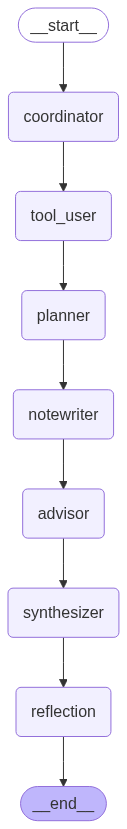

In [40]:
from IPython.display import Image, display

try:

    graph = app.get_graph()


    png_data = graph.draw_mermaid_png()


    display(Image(png_data))

except Exception as e:
    print(f"Lỗi khi vẽ graph: {e}")